# Efficiency by aircraft type

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors

In [3]:
aircrafts = pd.read_csv("../data/by_aircrafttype.csv")
aircrafts


,aircraftiatacode,airlines,avg_distance,flown_distance,gcd,flights,passengers,seats,average_load,co2,gco2_pax_km
0,320,201,1290.353509,6.887622e+09,6.403206e+09,5337779,7.448377e+08,916999968,0.810203,7.951892e+07,91.852775
1,73H,57,1488.731701,3.518290e+09,3.299291e+09,2363280,3.619091e+08,426446117,0.845671,4.160391e+07,84.161219
2,738,99,1474.877385,3.632981e+09,3.404605e+09,2463243,3.311885e+08,422482143,0.782759,3.972434e+07,87.358750
3,321,92,1550.889075,3.079456e+09,2.893377e+09,1985607,3.143021e+08,393551000,0.796832,4.274776e+07,95.511660
4,319,68,1148.747855,1.634823e+09,1.509990e+09,1423135,1.577783e+08,195029415,0.806593,1.857196e+07,114.455800
...,...,...,...,...,...,...,...,...,...,...,...
111,D38,1,598.517578,3.208054e+05,2.832054e+05,536,1.220304e+04,15544,0.785064,1.393368e+03,191.446537
112,EP3,1,2119.644830,3.018374e+06,2.875974e+06,1424,9.214142e+03,11392,0.808826,6.978331e+03,357.733646
113,M88,1,1078.862158,6.904718e+04,6.264718e+04,64,8.960248e+03,11008,0.813976,1.088772e+03,113.744713
114,313,1,2482.329026,9.432850e+04,9.052850e+04,38,4.365961e+03,7600,0.574469,1.666582e+03,170.316653


# Sort aircafts by passenger distance

In [247]:
intensity = np.array(aircrafts['gco2_pax_km'])
co2 = np.array(aircrafts['co2'])
passenger_distance = np.array(aircrafts['passengers'] / aircrafts['flights'] * aircrafts['flown_distance'])
code = np.array(aircrafts['aircraftiatacode'])
order = np.argsort(passenger_distance)

intensity = intensity[order]
co2 = co2[order] / 1000**2  # tCO2 to MtCO2
code = code[order]
light_year = 9.46073e12  # in kilometers
passenger_distance = passenger_distance[order] / light_year   # in light years
passenger_distance_accumulated = np.hstack((np.zeros(1), np.cumsum(passenger_distance)))


In [248]:
# rename some aircraft codes to their full names by hand
code[code == '320'] = 'Airbus A320-100/200'
code[code == '77W'] = 'Boeing 777-300ER'
code[code == '73H'] = 'Boeing 737-800 (w)'  # with winglets
code[code == '738'] = 'Boeing 737-800'
code[code == '321'] = 'Airbus A321-100/200'
code[code == '789'] = 'Boeing 787-9'
code[code == '359'] = 'Airbus A350-900'
code[code == '333'] = 'Airbus A330-300'
code[code == '32Q'] = 'Airbus A321neo'
code[code == '788'] = 'Boeing 787-8'
code[code == '388'] = 'Airbus A380-800'
code[code == '319'] = 'Airbus A319'
code[code == '7M8'] = 'Boeing 737 MAX 8'
code[code == '32N'] = 'Airbus A320neo'
code[code == '739'] = 'Boeing 737-900'      # with or without ER
code[code == '332'] = 'Airbus A330-200'
code[code == '32A'] = 'Airbus A320 (s)'     # s=sharklets


# Plotting

Plot the accumulated passenger distance across all aircraft types to create a bar plot with intensity on the y-axis, passenger distance on the x-axis so that the area of the bar is the co2 of that aircraft type

In [249]:
# truncated colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('magma_r')
new_cmap = truncate_colormap(cmap, 0.1, 0.6)

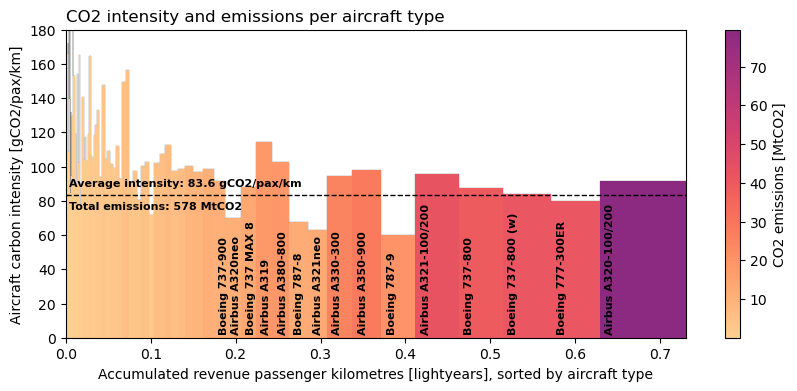

In [256]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.stairs(intensity, passenger_distance_accumulated, color='black', linewidth=0.3, edgecolor='black', alpha=.5)

cmap = plt.get_cmap("magma_r")
ax.bar(passenger_distance_accumulated[:-1], intensity,
       width=passenger_distance,
       color = new_cmap(co2/co2.max()),
       align='edge', edgecolor='none')

# manual colorbar
norm = colors.Normalize(vmin=co2.min(),vmax=co2.max())
sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='CO2 emissions [MtCO2]')

# add aircraft type labels
n = 15
for i, txt in enumerate(code[-n:]):
    i += len(passenger_distance) - n
    ax.annotate(txt, (passenger_distance_accumulated[i], 0),
                    xytext=(4, 4), textcoords='offset points', fontsize=8, rotation=90, color="black", fontweight='bold')


# add total emissions
co2_total = co2.sum()
intensity_avg = 1000**4 * co2_total / (passenger_distance.sum() * light_year)
ax.hlines(intensity_avg, 0, passenger_distance_accumulated[-1], color='black', linestyle='--', linewidth=1)
ax.annotate(f"Average intensity: {intensity_avg:.1f} gCO2/pax/km \n\nTotal emissions: {co2_total:.0f} MtCO2",
            xy=(0, intensity_avg), xycoords='data',
            xytext=(2, 0), textcoords='offset points', fontsize=8,
            horizontalalignment='left', verticalalignment='center', color="black", fontweight='bold')

ax.set_xlim(0, passenger_distance_accumulated[-1])
ax.set_ylim(0, 180)
ax.set_title("CO2 intensity and emissions per aircraft type", loc='left')
ax.set_xlabel("Accumulated revenue passenger kilometres [lightyears], sorted by aircraft type")
ax.set_ylabel("Aircraft carbon intensity [gCO2/pax/km]")

plt.show()

Fig ?: CO2 intensity and emissions per aircraft type. Aircrafts are sorted by their revenue passenger kilometres (RPK, denoted in light years, 1ly = $9.46073*10^{12}$ km) and horizontally stacked on the x-axis (accumulating RPK). The height of each bar denotes the aircraft's carbon intensity, the area is proportional to the CO2 emissions from that aircraft type and coloured accordingly. The 15 most prominent aircraft types (in terms of RPK) are denoted, (w) stands for (winglets). Average intensity is given as horizontal dashed line and the total emissions is the area below.